# Using convolution neural network with to classify fruit images
This kernel is a continuation of https://www.kaggle.com/rehanali88/kaggle-for-deep-learning-p-1-getting-data-ready. In that kernel we had split the data in to training, validation and test data sets. We will use the output of that kernel as our input data. 
We will use keras library to build a convolution neural network to classify fruit images into different categories. 

## Importing required packages
Let's first import the packages we will need for our analysis. The comments show the usage of every package we are importing.

In [1]:
# the following line will make plots appear with out calling plt.show()
%matplotlib inline

import numpy as np # linear algebra
import matplotlib.pyplot as plt # basic plotting
import pandas as pd # I/O of data sets
from collections import OrderedDict # making ordered dictionaries
import matplotlib.image as im # reading image files
import os, random, shutil # directory operations
from zipfile import ZipFile # woking with zip archives

# keras for deep learning
from keras import layers 
from keras import models 
from keras import optimizers 
from keras.preprocessing.image import ImageDataGenerator 

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Unzipping the data sets
Our input data is in a zipped format. We need to unzip these files.

First, let's make a list of the names of the zip files that we need to unzip.

In [2]:
zp_filenames = ['Testing.zip','Training.zip','Validation.zip']

Using the filenames we create a list of zipped files with their paths.

In [3]:
zp_filenamesWithpath = [os.path.join('../input',k) for k in zp_filenames] # using list 
#comprehension to build a list for zipped file with their path names. 

Let's now use the created list with 'ZipFile' package to extract the files to the current directory.

In [4]:
for k in zp_filenamesWithpath: # looping over the files that need to be unzipped
    # extracting the zipfiles to the current directory
    with ZipFile(k,'r') as zp: 
        zp.extractall()

## Getting parameter values that we will use when we build the model
Now we will extract some valuable information from the data, such as the number of images in each data set. We will also use this opportunity to make sure that every data set has the same classes. In addition, we will calculate some important parameters which we will use when we are building our model. 

First, we create a list with paths to the data sets.

In [5]:
paths_list = ['working/Validation', 'working/Training', 'working/Test']

In the following code, we perform the following tasks:   
1.  Calculate number of images in each data set.
2. Make sure that every data set has the same classes.

In [6]:
dict_num_images = OrderedDict() # creating an ordered dictionary to store number of 
# images
number_classes = [] # creating a list to store number of classes in each data set

for pa in paths_list: # looping over the list with paths to the data sets which we 
# created earlier
    number_classes.append(len(os.listdir(pa))) # appending the number of classes in a 
    # data set to the list number_classes
    nums = 0 # we will store the number of images in each class to this variable
    
    for idx, dr in enumerate(os.listdir(pa)): # looping over the classes in a data set
        nums += (len(os.listdir(os.path.join(pa,dr)))) # appending the number of images
        # in a class to the variable nums
        
    dict_num_images[pa[8:]] = nums # storing number of images in a data set to a 
    # dictionary with key = name of the data set
    
print('This dictionary shows number of images corresponding to a set:\n {}'
      .format(dict_num_images)) # printing the dictionary with the of images in each 
# data set
print(len(np.unique(number_classes)) == 1) # making sure that number of classes in 
#each data set is the same
print('The number of classes = {} '.format(np.unique(number_classes)[0])) # printing 
# the number of classes

This dictionary shows number of images corresponding to a set:
 OrderedDict([('Validation', 8752), ('Training', 34641), ('Test', 2888)])
True
The number of classes = 69 


Now we calculate some parameters which we will use when we are building our model. We will use ImageDataGenerator from keras to build our model. The generator object generates images in batches. For this generation we need to calculate the size of a certain batch. 
When we are fitting the generator, we will need to input the number of steps that the fitting process should take per epoch. This number when multiplied with the batch size should equal the total number of images in each data set.

In [7]:
dict_batchsize = OrderedDict() # creating an ordered dictionary to store the batch size
# for each data set
dict_epochno = OrderedDict() # creating an ordered dictionary to store the steps per 
# epoch for each data set
dic_keys = list(dict_num_images.keys()) # creating a list for the names data sets
dic_values = list(dict_num_images.values()) # creating a list for the number of images
# in each data set

for ind,key in enumerate(dic_keys): # looping over the data sets
    
    for nums in range(10,50): # looping over a range of numbers from 10 -50 
        # (these numbers are the potential batch size)
        
        if dic_values[ind]%nums == 0: # checking if the remainder of number of 
            # images/batch size is equal to zero
            dict_batchsize[key] = nums # if the remainder is zero, store the batch size
            # to the dictionary that was created earlier with key equal to the name of  
            # thedata set
            dict_epochno[key] = int(dic_values[ind]/nums) # calculating the steps per 
            # epoch by diving the number of images in a data set by the batch size and 
            # storing the value to the dictionary that was created earlier with key equal
            # to the name of the data set
            break; # as we have found a batch size, we break the loop
            
print('This dictionary shows batch sizes corresponding to a set:\n {}'.
      format(dict_batchsize)) # printing batch sizes
print('This dictionary shows number of step per epoch corresponding to a set:\n {}'.
      format(dict_epochno)) # printing steps per epoch

This dictionary shows batch sizes corresponding to a set:
 OrderedDict([('Validation', 16), ('Training', 27), ('Test', 19)])
This dictionary shows number of step per epoch corresponding to a set:
 OrderedDict([('Validation', 547), ('Training', 1283), ('Test', 152)])


This part is only a sanity check. If our calculations of batch sizes and steps per epoch are correct then batch size multiplied by the steps per epoch should be equal to the total number of images for a specific data set. So, every line of code in the following cell should print 'True'

In [8]:
print(dict_num_images['Validation'] == dict_batchsize['Validation']*
      dict_epochno['Validation'])
print(dict_num_images['Training'] == dict_batchsize['Training']*
      dict_epochno['Training'])
print(dict_num_images['Test'] == dict_batchsize['Test']*dict_epochno['Test'])

True
True
True


## Building and compiling the convolution neural network
Now we build a convolution network. We will use a number of convolution + max pooling layers. At the end we will add a flatten layer followed by a dense layer. Lastly, as we have multiple classification labels we will use sofmax activation for our output layer and the size of the output will be set to the the number of classes for the data set. 
The input shape for the first convolution layer is set to (100, 100, 3), which is the image size of our data.

Building the covnet

In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), 
                        activation='relu', 
                        input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), 
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), 
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), 
                        activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) # adding a flatten layer and a dropout layer
model.add(layers.Dense(512, 
                       activation='relu')) # adding a dense layer
model.add(layers.Dense(np.unique(number_classes)[0], 
                       activation='softmax')) # adding the final layer with outputs
# equal to the number of classes and using softmax as activation

In [10]:
# Checking the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
__________

Now we compile the model using accuracy as our metric and categorical crossentropy as the loss function as we have multiple classes. The optimizer we will use is the commonly used 'RMSprpop'

In [11]:
# Compiling the model with categorical crossentropy for multiclass labels
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Transforming data to use for fitting to the model.
We will use ImageDataGenerator to get the data ready for input to our model. We will scale the image so that pixel values are between 0 and 1.  Then we will use the generator object to generate batches of images for every data set.
We have already calculated the batch size for every data set.

In [12]:
# Making an image data generator object 
datagen = ImageDataGenerator(rescale=1./255)

In [13]:
# Using the generator for training directory
train_generator = datagen.flow_from_directory(paths_list[1],
                                              target_size = (100,100),
                                              batch_size=dict_batchsize['Training'],
                                              class_mode='categorical')

Found 34641 images belonging to 69 classes.


In [14]:
# Using the generator validation directory
validation_generator = datagen.flow_from_directory(paths_list[0],
                                                   target_size = (100,100),
                                                   batch_size=dict_batchsize[
                                                       'Validation'],
                                                   class_mode='categorical')

Found 8752 images belonging to 69 classes.


## Fitting the model
Now we are ready to fit the model. We already have calculated all the parameters that we need to input to the fit_generator method.

In [15]:
# Fitting the model using the train_generator
history = model.fit_generator(train_generator,
                              steps_per_epoch=dict_epochno['Training'],
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=dict_epochno['Validation'])

Epoch 1/50
1283/1283 [==============================] - 47s 37ms/step - loss: 1.0178 - acc: 0.7250 - val_loss: 0.4809 - val_acc: 0.8664
Epoch 2/50
1283/1283 [==============================] - 43s 34ms/step - loss: 0.1188 - acc: 0.9669 - val_loss: 0.2316 - val_acc: 0.9391
Epoch 3/50
1283/1283 [==============================] - 43s 34ms/step - loss: 0.0593 - acc: 0.9845 - val_loss: 0.1979 - val_acc: 0.9405
Epoch 4/50
1283/1283 [==============================] - 43s 33ms/step - loss: 0.0364 - acc: 0.9905 - val_loss: 0.1780 - val_acc: 0.9498
Epoch 5/50
1283/1283 [==============================] - 43s 33ms/step - loss: 0.0290 - acc: 0.9912 - val_loss: 0.1354 - val_acc: 0.9590
Epoch 6/50
1283/1283 [==============================] - 43s 33ms/step - loss: 0.0232 - acc: 0.9919 - val_loss: 0.1331 - val_acc: 0.9622
Epoch 7/50
1283/1283 [==============================] - 43s 33ms/step - loss: 0.0202 - acc: 0.9924 - val_loss: 0.1322 - val_acc: 0.9628
Epoch 8/50
1283/1283 [==========================

## Saving and plotting
We will now save the model. This is important as we can use this model to train related images, for example images of vegetables. As the features for fruits and vegetables are similar we can freeze some convolution and max pooling layers and train the model on vegetables. More importantly the same model can be used to train new classes of images. This will save alot of training time and will require a smaller number of samples. We also need to plot loss and accuracy vs epoch number to test for overfitting.

First let's save the model and it's weights.

In [16]:
model_json = model.to_json() # serialize model to JSON
# writing the model as a json file
with open("fruit_classification_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("fruit_classification_weights.h5") # saving model weights as HDF5
print("Model Saved")

Model Saved


Now we plot loss and accuracy vs epoch number for validation and training data.

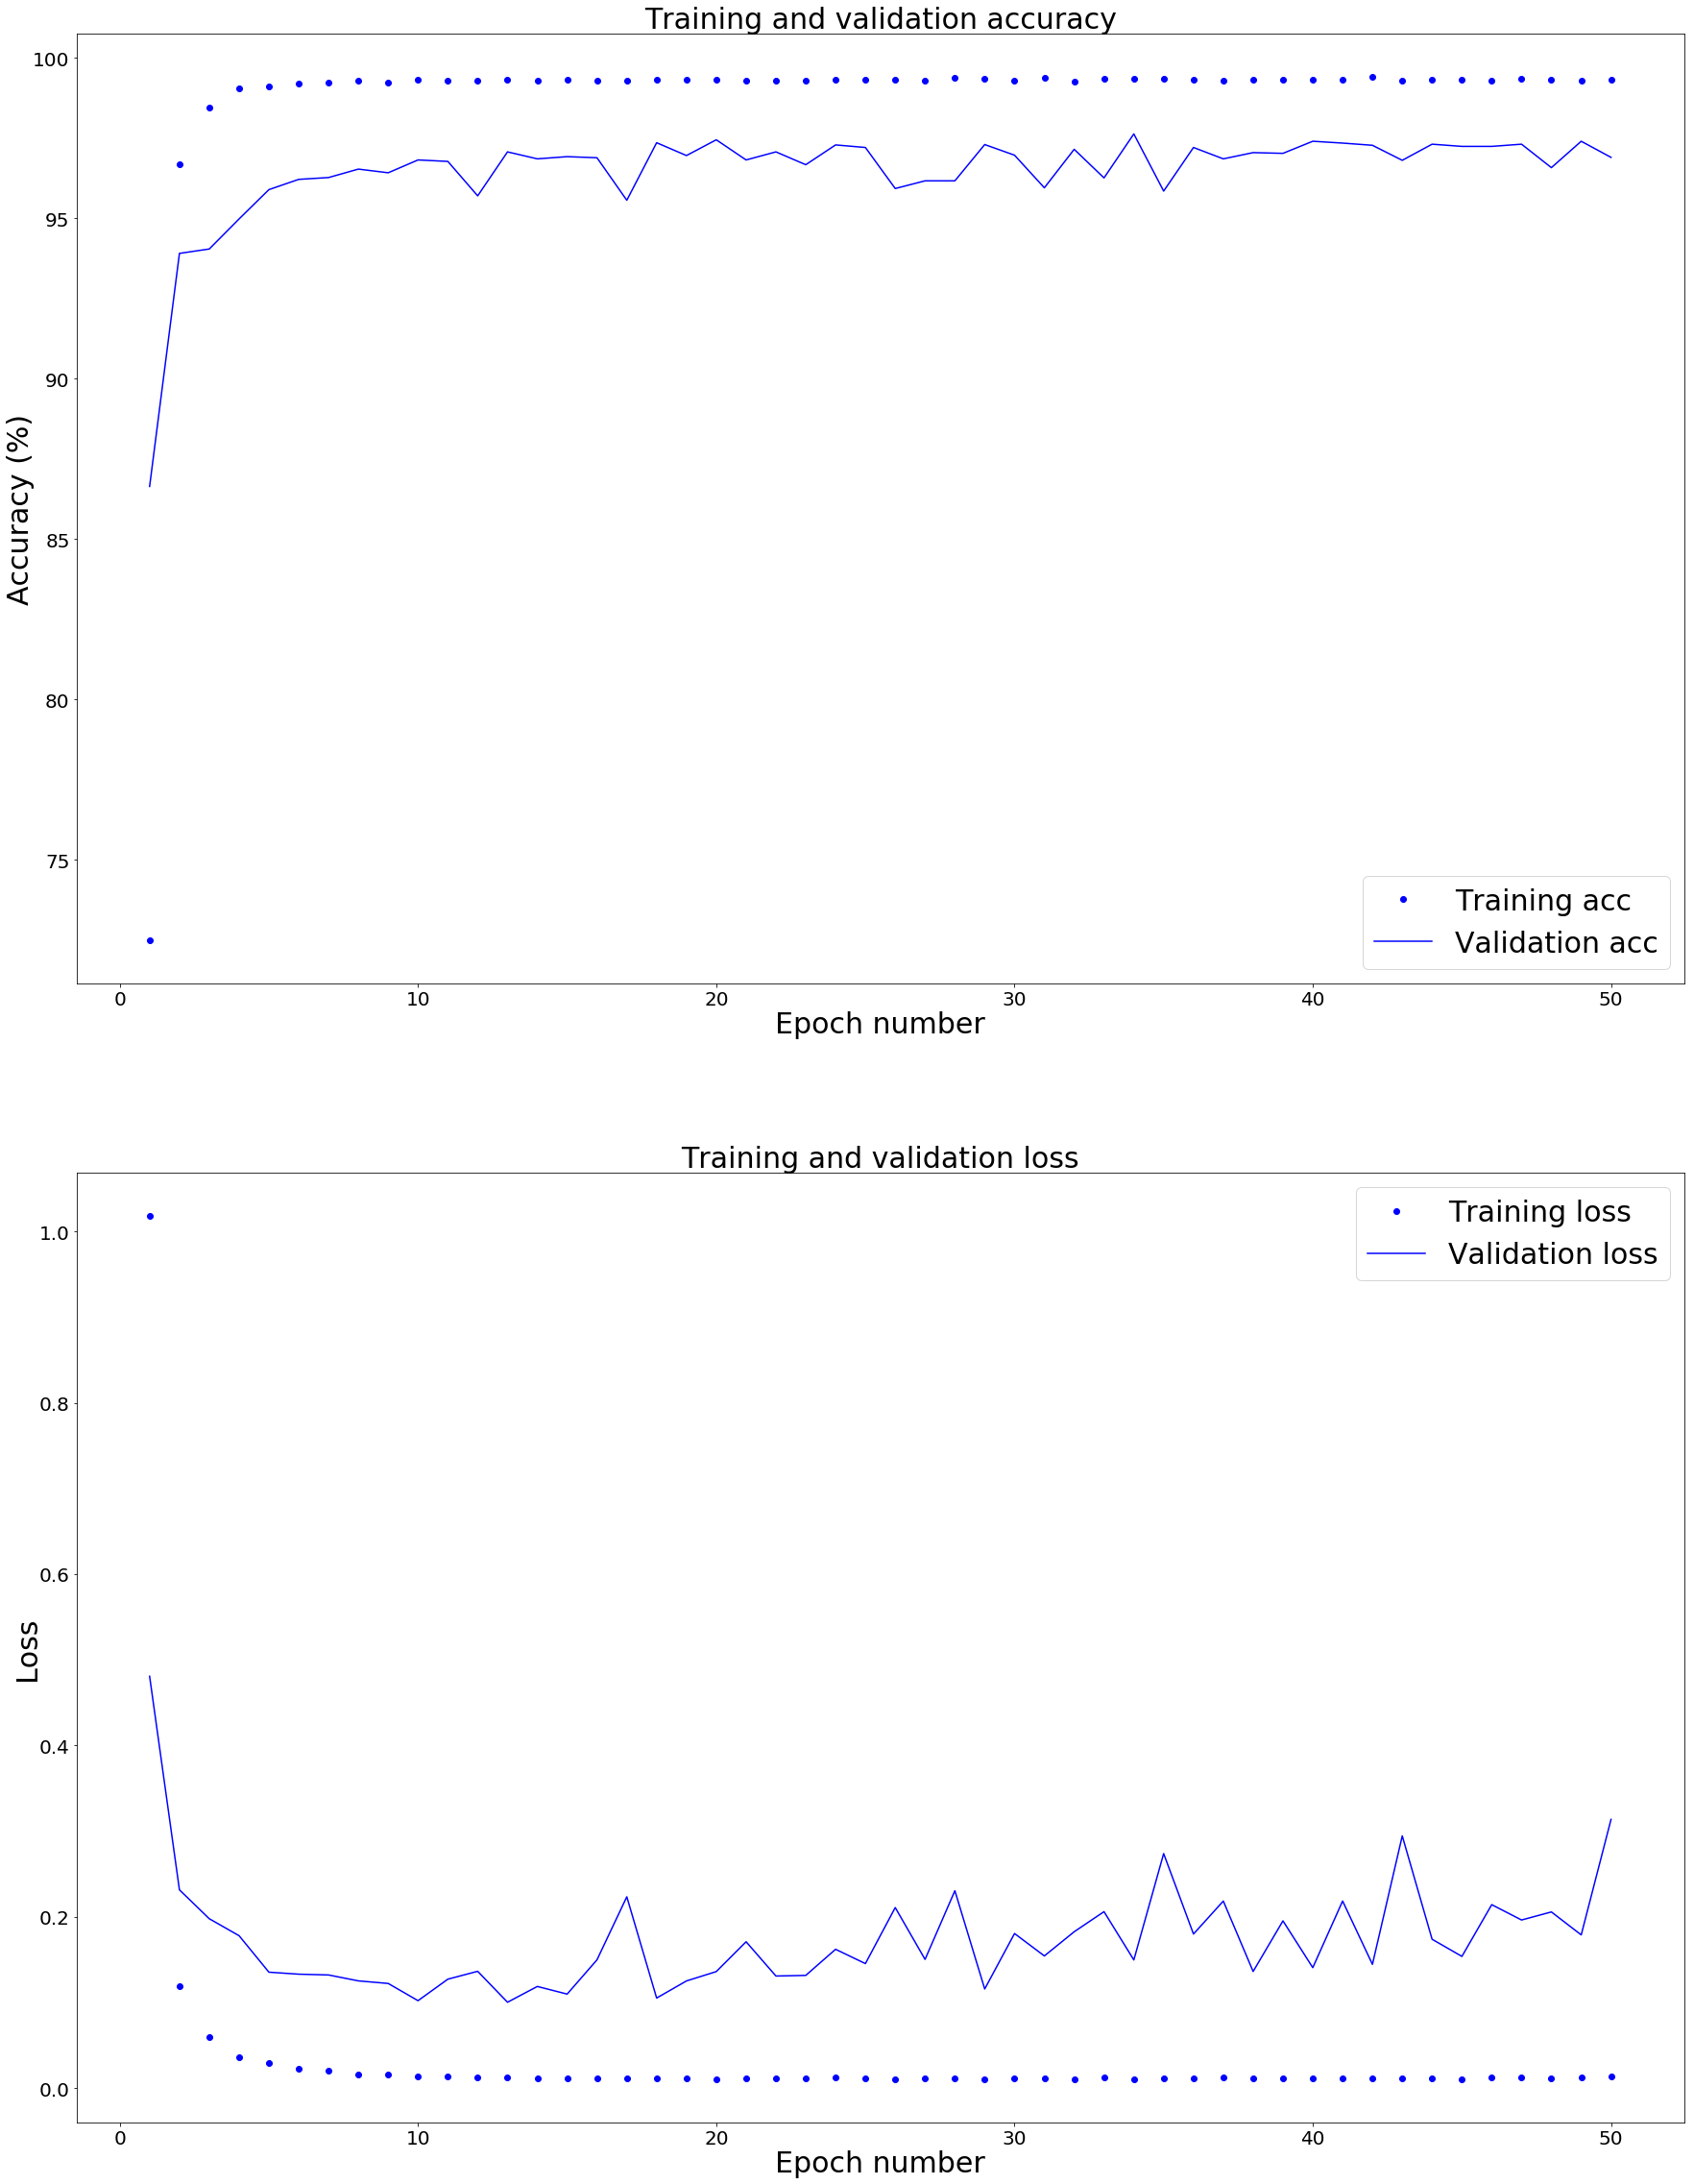

In [17]:
fg, (ax1, ax2) = plt.subplots(2,1,figsize = (30, 40)) # creating subplots

# calculating percentage accuracy and loss for training and validation
acc = np.array(history.history['acc'])*100
val_acc = np.array(history.history['val_acc'])*100
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1) # calculating x-axis values
fnt = {'fontsize': 30,
       'fontweight' : 'medium',
       'verticalalignment': 'baseline'} # dictionary to control font for labels & title

# plotting accuracy
ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy', fnt)
ax1.set_xlabel('Epoch number', fnt, labelpad = 25)
ax1.set_ylabel('Accuracy (%)', fnt)
ax1.legend(fontsize = 30)

# plotting loss
ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss', fnt)
ax2.set_xlabel('Epoch number', fnt, labelpad = 25)
ax2.set_ylabel('Loss', fnt)
ax2.legend(fontsize = 30)

# changing font size of tick labels
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

fg.savefig('modelResults.png')# saving the figure

## Insights from the plots
The following points are to be noted from the plots above:
1. After epoch number 10, both the training accuracy and loss do not change alot.
2. The validation loss and accuracy never reach the traing loss and accuracy.
3. After epoch number 10, the validation loss seems to increase as the epoch number increases.

To see, if our observation in point-3 is correct lets redraw the plot for loss vs epoch number using values starting from epoch number 10.

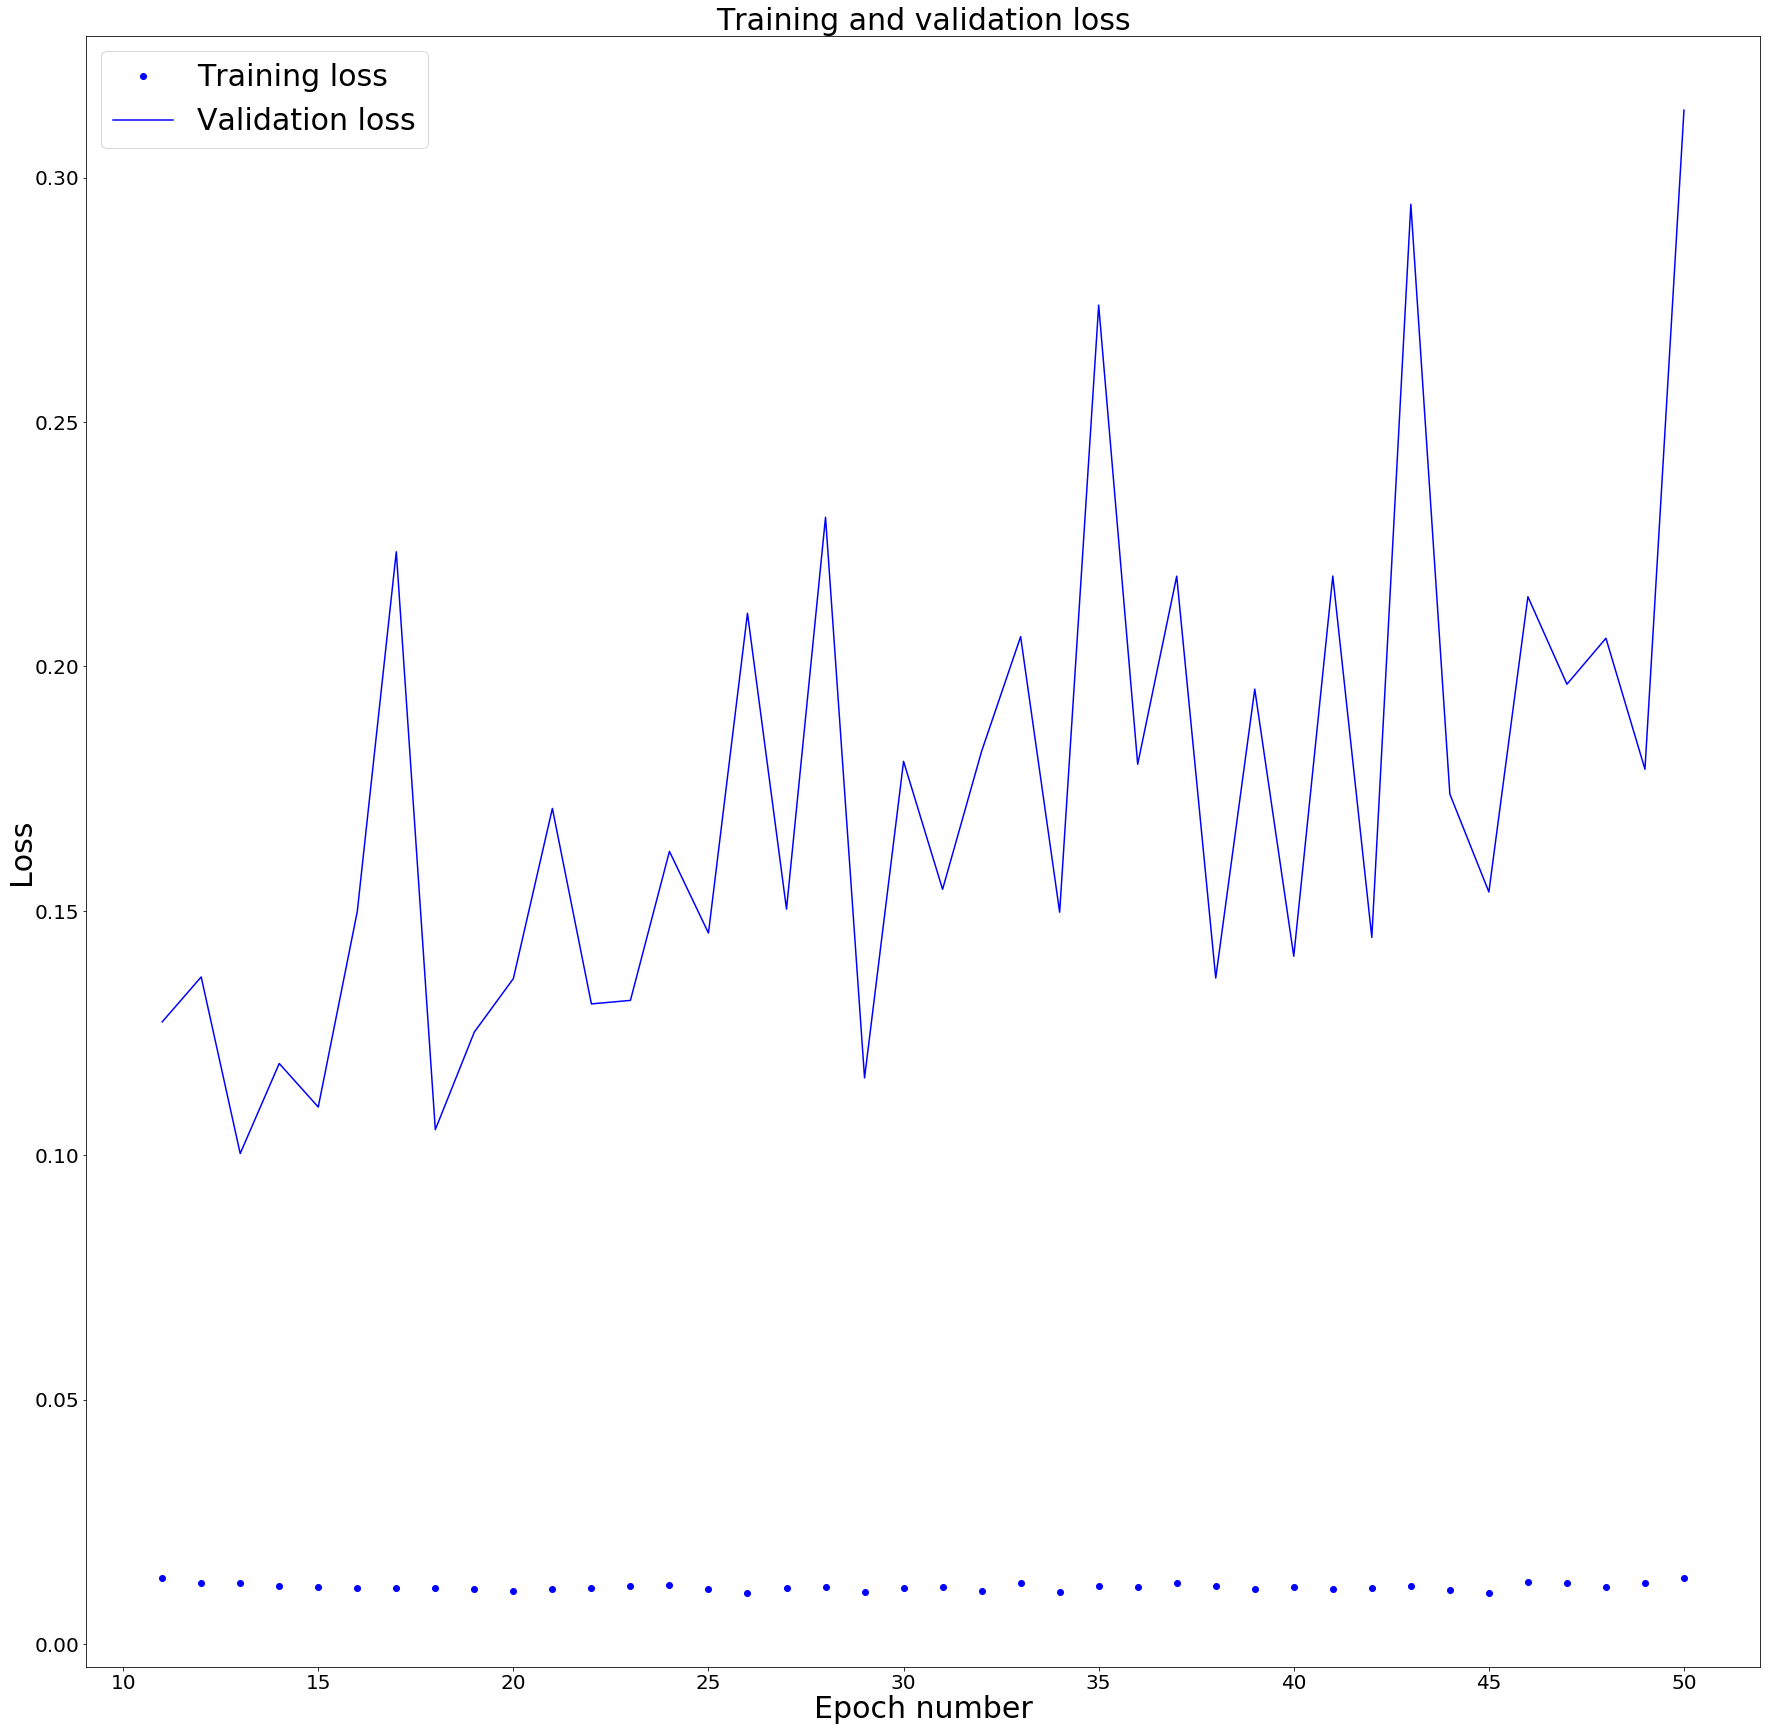

In [18]:
fg2, ax = plt.subplots(1,1,figsize = (30, 30)) # creating figure and axis objects

# plotting loss after epoch no 10 using parameters already created before
ax.plot(epochs[10:], loss[10:], 'bo', label='Training loss')
ax.plot(epochs[10:], val_loss[10:], 'b', label='Validation loss')
ax.set_title('Training and validation loss', fnt)
ax.set_xlabel('Epoch number', fnt, labelpad = 25)
ax.set_ylabel('Loss', fnt)
ax.legend(fontsize = 30)

# changing font size of tick labels
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)

fg2.savefig('lossAfterEpoch10.png')# saving the figure

As we had observed, the validation loss shows a slight but steady increase as epoch number increases.  Also, there is alot of variability in the vaidation loss. **What this shows is that we might be overfitting the data. In other terms, the model might be memorizing instead of learning!. We will solve this in the last part of this project using image augmentation**.  But, more on that later. For now, let's just print the validation accuracy for the last epoc

In [19]:
print('Validation accuracy at the last epoch is: {} %'.format(val_acc[-1]))

Validation accuracy at the last epoch is: 96.90356489945155 %


## Model results 
The model gives us a validation accuaracy of 96.6%. We will compare this to the model that we build using image augmentation to see if the results improve. 

## Testing the model
Now let's test the model on the test data set. As before we will generate batches of images for the test data. Then we will use 'evaluate_generator' method to calculate loss and accuracy for the test data.

In [20]:
# Creating the test_generator
test_generator = datagen.flow_from_directory(paths_list[2],
                                             target_size = (100,100),
                                             batch_size=dict_batchsize['Test'],
                                             class_mode='categorical')

Found 2888 images belonging to 69 classes.


In [21]:
test_loss, test_acc = model.evaluate_generator(test_generator,
                                               steps=dict_epochno['Test']) #
# calculating the test loss and accuracy
print('Test accuracy for the model is {} %'. format(test_acc*100)) # printing the test
# loss and accuracy

Test accuracy for the model is 96.1565103970076 %


## Model accuracy for test data
The model gives us an accuracy of 96.6 % on test data. Again, we will compare this value to the model that we will build using image augmentation.

## Summarizing important results
1. Validation loss shows a slight but steady increase as epoch number increases along with high variability.
2. Validation loss and accuracy never reach the values close to training loss and accuracy.
3. We might be overfitting the data.
4. The accuracy on the training data set and validation data set is around 96.6 %.
      
In the next part of the project we will use image augmentation and see if we are able to overcome the above mentioned issues.

Finally we need to check the contents of the current directory. The contents of this directory will be saved as output. Some of the saved output will be important for us in the next part of the project.

In [22]:
os.listdir()

['lossAfterEpoch10.png',
 'working',
 '.ipynb_checkpoints',
 'fruit_classification_weights.h5',
 'modelResults.png',
 'fruit_classification_model.json',
 '__notebook_source__.ipynb']

We see that we have all the images from the input (that we unzipped) in the working directory. We do not need these as we already have saved them before, so let's remove them. 

In [23]:
shutil.rmtree('working')

This will be the last step of this part of the project. In the next part we will build a model using image augmentation and compare the results with the model that we just created.